In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import emoji

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show full text without truncation
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 500) 

##### Step 1: Loading the Raw Files 

This step involves loading the provided datasets — videos and comments.

In [3]:
# Loading & joining the multiple comments datasets into one
filepaths = [
    "comments1.csv",
    "comments2.csv",
    "comments3.csv",
    "comments4.csv",
    "comments5.csv"
]
comments_list = [pd.read_csv(fp) for fp in filepaths]
comments_df = pd.concat(comments_list, ignore_index=True)
comments_df.to_csv("comments_all_raw.csv", index=False)

# Loading the comments dataset
comments_df = pd.read_csv("comments_all_raw.csv")

# Loading the videos dataset
videos_df = pd.read_csv("videos.csv")

##### Step 2: Data Understanding 

This step provides an overview of the datasets, including their size, available features, data types, and the extent of missing values. The goal is to identify potential issues and outline the preprocessing steps required before deeper analysis.

In [ ]:
# Quick look at the data
print("videos:", videos_df.shape)
print("comments:", comments_df.shape)
display(videos_df.head(3).T)
display(comments_df.head(3).T)

videos: (92759, 15)
comments: (4725012, 10)


,0,1,2
kind,youtube#video,youtube#video,youtube#video
videoId,85806,30556,51771
publishedAt,2024-01-15 00:59:29+00:00,2023-10-27 19:32:16+00:00,2024-09-28 01:23:22+00:00
channelId,33807,46650,14346
title,Unlocking the Benefits of Face Masks for Skin Health,Get ready for the Magic💚💜🤍💝✨ #hydration #glowingskin #nomakeuplook #skincare,#trending #makeup #beautymakeup #yslbeauty #luxury #latina #fyp
description,NaN,NaN,NaN
tags,NaN,NaN,NaN
defaultLanguage,en-US,NaN,NaN
defaultAudioLanguage,en-US,NaN,en-US
contentDuration,PT9S,PT45S,PT19S


,0,1,2
kind,youtube#comment,youtube#comment,youtube#comment
commentId,1781382,289571,569077
channelId,14492,14727,3314
videoId,74288,79618,51826
authorId,2032536,3043229,917006
textOriginal,PLEASE LESBIAN FLAG I BEG YOU \n\nYou would rock it,Apply mashed potato juice and mixed it with curd,69 missed calls from mars👽
parentCommentId,NaN,3198066.0,NaN
likeCount,0,0,0
publishedAt,2023-08-15 21:48:52+00:00,2023-10-02 13:08:22+00:00,2024-05-31 12:03:12+00:00
updatedAt,2023-08-15 21:48:52+00:00,2023-10-02 13:08:22+00:00,2024-05-31 12:03:12+00:00


In [ ]:
# Data types and missing values
videos_df.info()
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92759 entries, 0 to 92758
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   kind                  92759 non-null  object 
 1   videoId               92759 non-null  int64  
 2   publishedAt           92759 non-null  object 
 3   channelId             92759 non-null  int64  
 4   title                 92759 non-null  object 
 5   description           35237 non-null  object 
 6   tags                  20891 non-null  object 
 7   defaultLanguage       15785 non-null  object 
 8   defaultAudioLanguage  29956 non-null  object 
 9   contentDuration       91492 non-null  object 
 10  viewCount             91490 non-null  float64
 11  likeCount             86630 non-null  float64
 12  favouriteCount        91492 non-null  float64
 13  commentCount          90294 non-null  float64
 14  topicCategories       91228 non-null  object 
dtypes: float64(4), int6

In [ ]:
# Analysing null values in comments dataset
comments_df_null_summary = pd.DataFrame({
    "Column": comments_df.columns,
    "DataType": comments_df.dtypes.values,
    "NullValues": comments_df.isnull().sum().values,
    "NullPercentage": (comments_df.isnull().sum() / len(comments_df) * 100).values
})

comments_df_null_summary


,Column,DataType,NullValues,NullPercentage
0,kind,object,0,0.000000
1,commentId,int64,0,0.000000
2,channelId,int64,0,0.000000
3,videoId,int64,0,0.000000
4,authorId,int64,0,0.000000
5,textOriginal,object,257,0.005439
6,parentCommentId,float64,4208877,89.076536
7,likeCount,int64,0,0.000000
8,publishedAt,object,0,0.000000
9,updatedAt,object,0,0.000000


In [ ]:
# Analysing null values in videos dataset
videos_df_null_summary = pd.DataFrame({
    "Column": videos_df.columns, 
    "DataType": videos_df.dtypes.values,
    "NullValues": videos_df.isnull().sum().values,
    "NullPercentage": (videos_df.isnull().sum() / len(videos_df) * 100).values
})

videos_df_null_summary

,Column,DataType,NullValues,NullPercentage
0,kind,object,0,0.000000
1,videoId,int64,0,0.000000
2,publishedAt,object,0,0.000000
3,channelId,int64,0,0.000000
4,title,object,0,0.000000
5,description,object,57522,62.012311
6,tags,object,71868,77.478196
7,defaultLanguage,object,76974,82.982783
8,defaultAudioLanguage,object,62803,67.705560
9,contentDuration,object,1267,1.365905


In [ ]:
# Basic statistics of comments
comments_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
kind,4725012,1,youtube#comment,4725012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
commentId,4725012.0,NaN,NaN,NaN,2362507.290645,1363994.812942,0.0,1181253.75,2362506.5,3543761.25,4725015.0
channelId,4725012.0,NaN,NaN,NaN,26771.021648,15036.664358,1.0,14492.0,25425.0,40618.0,53677.0
videoId,4725012.0,NaN,NaN,NaN,46996.725556,25936.265814,0.0,25978.0,47096.0,69445.0,92854.0
authorId,4725012.0,NaN,NaN,NaN,1820728.772865,1053867.569091,0.0,906096.75,1813631.5,2731818.25,3659440.0
textOriginal,4724755,3753458,❤,20163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
parentCommentId,516135.0,NaN,NaN,NaN,2623663.140835,1215428.264227,516151.0,1569545.0,2625877.0,3677645.0,4725006.0
likeCount,4725012.0,NaN,NaN,NaN,10.127441,544.468922,0.0,0.0,0.0,0.0,456142.0
publishedAt,4725012,4610160,2023-11-01 11:08:00+00:00,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
updatedAt,4725012,4602175,2023-11-01 11:08:00+00:00,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Basic statistics of videos
videos_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
kind,92759,1,youtube#video,92759,NaN,NaN,NaN,NaN,NaN,NaN,NaN
videoId,92759.0,NaN,NaN,NaN,46422.873867,26802.952565,1.0,23214.5,46417.0,69633.5,92855.0
publishedAt,92759,92655,2021-06-07 22:14:03+00:00,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
channelId,92759.0,NaN,NaN,NaN,26676.485063,15529.198477,0.0,13240.5,26605.0,40145.5,53680.0
title,92759,84135,The Science of Exfoliation: Reveal Your Best Skin,519,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,35237,32018,".... Beauty Tips / Beauty Tips For Every Girl / Skin Care Tips / Makeup tutorial /#shorts\n\n.... .. beauty tips for girls,\nbeauty tips for face,\nbeauty tips tiktok,\nbeauty tips at home,\nbeauty tips asmr,\nbeauty tips aloe vera,\nbeauty tips diy\n \n #beautytips #makeup",141,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tags,20891,17571,"['Skin Care Tips', 'Beauty Tips', 'Makeup tutorial', 'beauty tips for girls', 'beauty tips for face', 'beauty tips tiktok', 'beauty tips at home', 'beauty tips asmr', 'beauty tips aloe vera', 'beauty tips diy', '#shorts']",141,NaN,NaN,NaN,NaN,NaN,NaN,NaN
defaultLanguage,15785,82,en-US,7048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
defaultAudioLanguage,29956,106,en-US,9339,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contentDuration,91492,1522,PT9S,6435,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Number of unique values in each column for comments dataset
comments_df.nunique()

kind                     1
commentId          4725012
channelId            24152
videoId              39938
authorId           3659437
textOriginal       3753458
parentCommentId     317069
likeCount             4921
publishedAt        4610160
updatedAt          4602175
dtype: int64

In [ ]:
# Number of unique values in each column for videos dataset
videos_df.nunique()

kind                        1
videoId                 92759
publishedAt             92655
channelId               53681
title                   84135
description             32018
tags                    17571
defaultLanguage            82
defaultAudioLanguage      106
contentDuration          1522
viewCount               21653
likeCount                7360
favouriteCount              1
commentCount             1645
topicCategories           187
dtype: int64

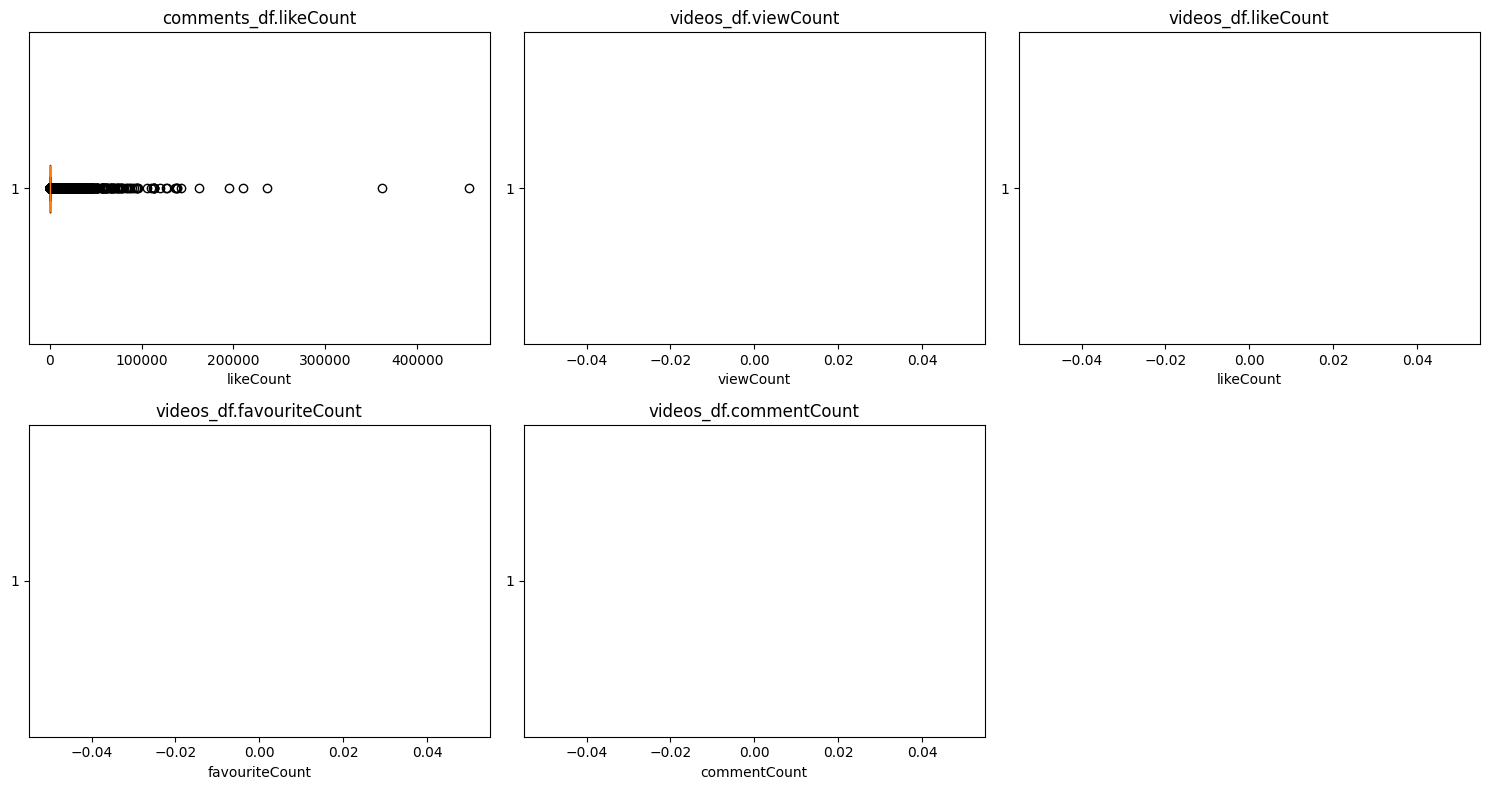

In [ ]:
# Visualizing distributions of key numeric columns

plt.figure(figsize=(15, 8))

# 1. comments_df.likeCount
plt.subplot(2, 3, 1)
plt.boxplot(comments_df['likeCount'], vert=False)
plt.title("comments_df.likeCount")
plt.xlabel("likeCount")

# 2. videos_df.viewCount
plt.subplot(2, 3, 2)
plt.boxplot(videos_df['viewCount'], vert=False)
plt.title("videos_df.viewCount")
plt.xlabel("viewCount")

# 3. videos_df.likeCount
plt.subplot(2, 3, 3)
plt.boxplot(videos_df['likeCount'], vert=False)
plt.title("videos_df.likeCount")
plt.xlabel("likeCount")

# 4. videos_df.favouriteCount
plt.subplot(2, 3, 4)
plt.boxplot(videos_df['favouriteCount'], vert=False)
plt.title("videos_df.favouriteCount")
plt.xlabel("favouriteCount")

# 5. videos_df.commentCount
plt.subplot(2, 3, 5)
plt.boxplot(videos_df['commentCount'], vert=False)
plt.title("videos_df.commentCount")
plt.xlabel("commentCount")

# layout adjustment
plt.tight_layout()
plt.show()

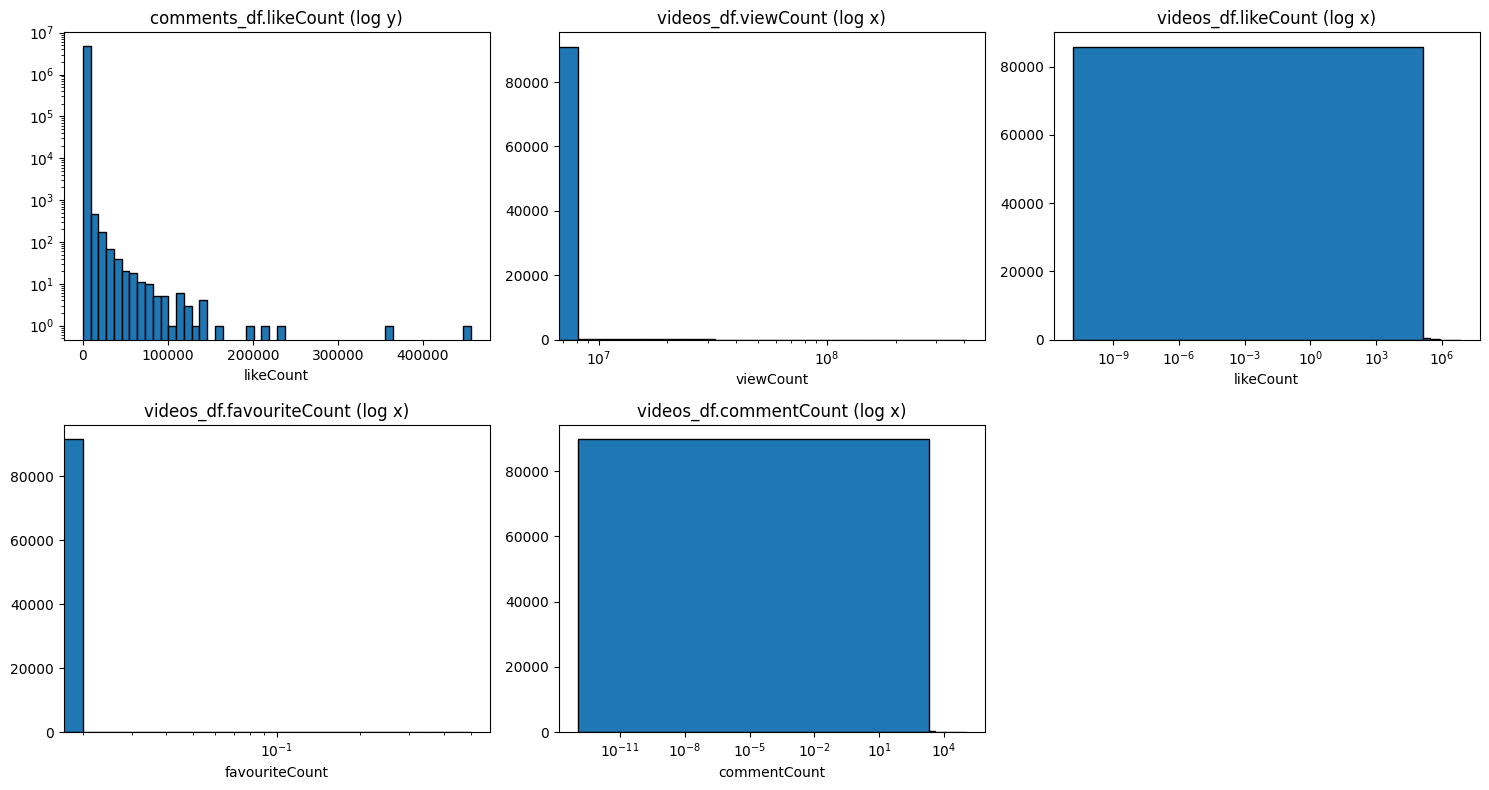

In [ ]:
# Visualizing distributions of key numeric columns in log scale to handle skewness

plt.figure(figsize=(15, 8))

# 1. comments_df.likeCount (log y-axis)
plt.subplot(2, 3, 1)
plt.hist(comments_df['likeCount'], bins=50, edgecolor="black", log=True)
plt.title("comments_df.likeCount (log y)")
plt.xlabel("likeCount")

# 2. videos_df.viewCount (log x-axis)
plt.subplot(2, 3, 2)
plt.hist(videos_df['viewCount'], bins=50, edgecolor="black")
plt.xscale("log")
plt.title("videos_df.viewCount (log x)")
plt.xlabel("viewCount")

# 3. videos_df.likeCount (log x-axis)
plt.subplot(2, 3, 3)
plt.hist(videos_df['likeCount'], bins=50, edgecolor="black")
plt.xscale("log")
plt.title("videos_df.likeCount (log x)")
plt.xlabel("likeCount")

# 4. videos_df.favouriteCount (log x-axis)
plt.subplot(2, 3, 4)
plt.hist(videos_df['favouriteCount'], bins=50, edgecolor="black")
plt.xscale("log")
plt.title("videos_df.favouriteCount (log x)")
plt.xlabel("favouriteCount")

# 5. videos_df.commentCount (log x-axis)
plt.subplot(2, 3, 5)
plt.hist(videos_df['commentCount'], bins=50, edgecolor="black")
plt.xscale("log")
plt.title("videos_df.commentCount (log x)")
plt.xlabel("commentCount")

# layout adjustment
plt.tight_layout()
plt.show()


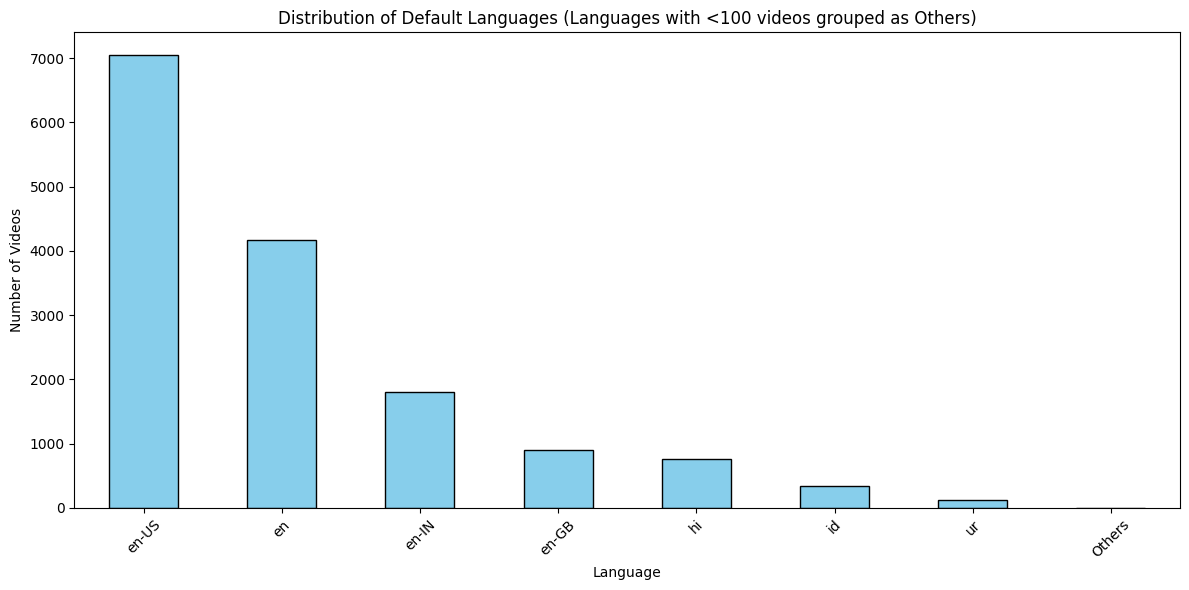

In [ ]:
# Analyzing distribution of defaultLanguage in videos dataset

# Count occurrences of each language
lang_counts = videos_df['defaultLanguage'].value_counts()

# Group languages with counts < 100 into 'Others'
lang_counts = lang_counts.apply(lambda x: x if x >= 100 else 0)
others_count = lang_counts[lang_counts == 0].sum()
lang_counts = lang_counts[lang_counts > 0]
lang_counts['Others'] = others_count

# Plot bar chart
plt.figure(figsize=(12, 6))
lang_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Language')
plt.ylabel('Number of Videos')
plt.title('Distribution of Default Languages (Languages with <100 videos grouped as Others)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


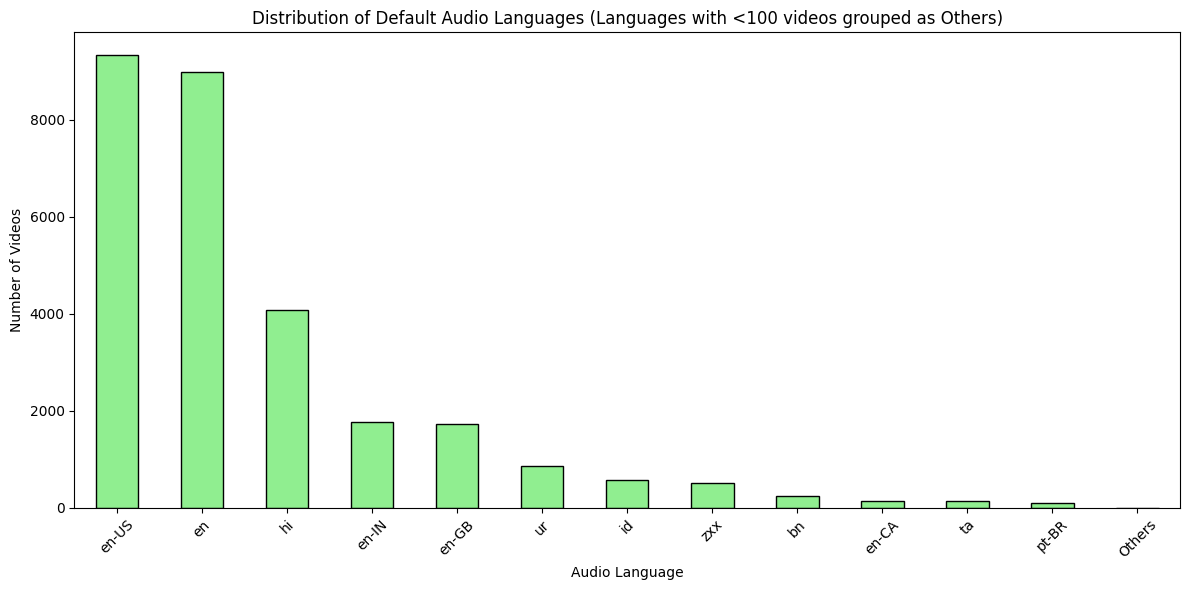

In [ ]:
# Analyzing distribution of defaultAudioLanguage in videos dataset

# Count occurrences of each audio language
audio_counts = videos_df['defaultAudioLanguage'].value_counts()

# Group languages with counts < 100 into 'Others'
audio_counts = audio_counts.apply(lambda x: x if x >= 100 else 0)
others_count = audio_counts[audio_counts == 0].sum()
audio_counts = audio_counts[audio_counts > 0]
audio_counts['Others'] = others_count

# Plot bar chart
plt.figure(figsize=(12, 6))
audio_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.xlabel('Audio Language')
plt.ylabel('Number of Videos')
plt.title('Distribution of Default Audio Languages (Languages with <100 videos grouped as Others)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


> **Dataset Overview & Data Quality Insights**
>
> The dataset consists of two tables: one with 92.8K YouTube videos and another with 4.7M comments.  
> - All ID fields (`videoId`, `channelId`, `authorId`, `commentId`) are currently stored as integers but should be cast to strings for consistency and to avoid errors when merging on these keys.
> - Timestamps (`publishedAt`, `updatedAt`) should be converted to datetime for proper temporal analysis.  
>
> **Videos Dataset**  
> - High proportions of missing values are observed in `description` (62%), `tags` (77%), `defaultLanguage` (83%), and `defaultAudioLanguage` (68%).  
> - Engagement metrics (`viewCount`, `likeCount`, `commentCount`, `favouriteCount`), `contentDuration` and `topicCategories` contain relatively few nulls (<7%).  
> - `favouriteCount` is uniformly zero or nulls and can be safely dropped.  
> - The `kind` column is redundant since it contains only a single value (`youtube#video`) and can also be removed.  
> - Among the non-null values for `defaultLanguage` and `defaultAudioLanguage`, the majority are English and Hindi. 
>
> **Comments Dataset**  
> - `textOriginal` has negligible missing values (<0.01%).  
> - `parentCommentId` is missing in 89% of rows, reflecting that most comments are top-level rather than replies.  
> - Other fields have no missing values.  
> - The `kind` column is again redundant (`youtube#comment`) and can be dropped.  
>
> **Distribution of Engagement Metrics**  
> - On the **normal scale**, engagement metrics (`viewCount`, `likeCount`, `commentCount` for videos and `likeCount` for comments) are highly **right-skewed**. Most observations cluster near zero, while a small number of entries show extremely large values (outliers).  
> - To better visualize these heavy-tailed distributions, the **logarithmic scale** was applied. This transformation reveals the spread of values more clearly, showing that the majority of videos and comments receive low engagement, while only a few achieve very high counts.  
> - For `favouriteCount`, the distribution is essentially flat, with values being either zero or null, confirming it carries little analytical value.  


##### Step 3: Remove Row Duplicates by `commentId` & `videoId`

This step identifies and removes duplicates based on unique identifiers.

In [ ]:
# Checking for duplicates based on commentId in comments_df and videoId in videos_df
print("Number of duplicates in comments:", comments_df.duplicated(subset=['commentId']).sum())
print("Number of duplicates in videos", videos_df.duplicated(subset=['videoId']).sum())

Number of duplicates in comments: 0
Number of duplicates in videos 0


> No duplicate records were found in the comments dataset based on `commentId`, and similarly, no duplicates were detected in the videos dataset based on `videoId`.  


##### Step 4: Column Pruning

This step removes non-informative or redundant columns to streamline the datasets and improve processing efficiency.

In [ ]:
# Dropping the redundant columns
videos_df = videos_df.drop(columns=['kind', 'favouriteCount'])
comments_df = comments_df.drop(columns=['kind'])

# checking the changes 
videos_df.columns, comments_df.columns

(Index(['videoId', 'publishedAt', 'channelId', 'title', 'description', 'tags',
        'defaultLanguage', 'defaultAudioLanguage', 'contentDuration',
        'viewCount', 'likeCount', 'commentCount', 'topicCategories'],
       dtype='object'),
 Index(['commentId', 'channelId', 'videoId', 'authorId', 'textOriginal',
        'parentCommentId', 'likeCount', 'publishedAt', 'updatedAt'],
       dtype='object'))

##### Step 5: Data Type Corrections

In this step, data type conversions are performed where necessary to ensure consistency and facilitate accurate analysis.

In [ ]:
# Converting dates to datetime
videos_df['publishedAt'] = pd.to_datetime(videos_df['publishedAt'])
comments_df['updatedAt'] = pd.to_datetime(comments_df['updatedAt'])
comments_df['publishedAt'] = pd.to_datetime(comments_df['publishedAt'])

# Converting ID fields to string
videos_df['videoId'] = videos_df['videoId'].astype(str)
videos_df['channelId'] = videos_df['channelId'].astype(str)
comments_df['commentId'] = comments_df['commentId'].astype(str)
comments_df['parentCommentId'] = comments_df['parentCommentId'].astype(str)
comments_df['channelId'] = comments_df['channelId'].astype(str)
comments_df['videoId'] = comments_df['videoId'].astype(str)
comments_df['authorId'] = comments_df['authorId'].astype(str)

# Checking the changes
videos_df.info()
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92759 entries, 0 to 92758
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   videoId               92759 non-null  object             
 1   publishedAt           92759 non-null  datetime64[ns, UTC]
 2   channelId             92759 non-null  object             
 3   title                 92759 non-null  object             
 4   description           35237 non-null  object             
 5   tags                  20891 non-null  object             
 6   defaultLanguage       15785 non-null  object             
 7   defaultAudioLanguage  29956 non-null  object             
 8   contentDuration       91492 non-null  object             
 9   viewCount             91490 non-null  float64            
 10  likeCount             86630 non-null  float64            
 11  commentCount          90294 non-null  float64            
 12  topi

##### Step 6: Handling Null Values

This step focuses on addressing the null values present in both datasets.

In [ ]:
# comments_df: Handling null values in 'textOriginal'
print(comments_df['textOriginal'].isnull().sum())

# checking the likeCount distribution for comments with null textOriginal
comments_df[comments_df['textOriginal'].isnull()]['likeCount'].value_counts()

# Before removing rows with null textOriginal
print("Before: ",comments_df.shape)

# removing rows with null textOriginal 
comments_df = comments_df[comments_df['textOriginal'].notnull()]

# After removing rows with null textOriginal
print("After: ", comments_df.shape)

257
Before:  (4725012, 9)
After:  (4724755, 9)


> Given that 257 rows constitute less than 1% of the dataset and the highest `likeCount` among them is below 5, it is reasonable to remove these rows.

> The `parentCommentId` column naturally contains many null values because only replies have a parent comment. Therefore, no treatment for missing values is necessary.

In [ ]:
# Build updated null summary for comments dataset
comments_df_null_summary_updated = pd.DataFrame({
    "Column": comments_df.columns,
    "DataType": comments_df.dtypes.values,
    "NullValues": comments_df.isnull().sum().values,
    "NullPercentage": (comments_df.isnull().sum() / len(comments_df) * 100).values
})

comments_df_null_summary_updated


,Column,DataType,NullValues,NullPercentage
0,commentId,object,0,0.0
1,channelId,object,0,0.0
2,videoId,object,0,0.0
3,authorId,object,0,0.0
4,textOriginal,object,0,0.0
5,parentCommentId,object,0,0.0
6,likeCount,int64,0,0.0
7,publishedAt,"datetime64[ns, UTC]",0,0.0
8,updatedAt,"datetime64[ns, UTC]",0,0.0


> All videos have a title. The fields `description`, `tags`, `defaultLanguage`, and `defaultAudioLanguage` are optional, so null values in these columns do not need to be removed or treated. A null value simply indicates that the uploader did not provide that information.

In [ ]:
cols_to_check = [
    "description", "tags", "defaultLanguage", "defaultAudioLanguage",
    "contentDuration", "viewCount", "likeCount", "commentCount", "topicCategories"
]

# Filter rows where all selected columns are null
display(videos_df[videos_df[cols_to_check].isnull().all(axis=1)].head(1).T)
videos_df[videos_df[cols_to_check].isnull().all(axis=1)].shape

,76
videoId,27628
publishedAt,2024-11-21 12:06:48+00:00
channelId,28923
title,"Skincare Tutorial, Beauty Tips #makeup #skincaretutorial #makeuptutorial #lipstick"
description,NaN
tags,NaN
defaultLanguage,NaN
defaultAudioLanguage,NaN
contentDuration,NaN
viewCount,NaN


(1267, 13)

In [ ]:
# Before removing rows with all nulls in cols_to_check
print("Before: ",videos_df.shape)

# Remove rows where all columns in cols_to_check are null
videos_df = videos_df.dropna(subset=cols_to_check, how='all')

# Check the result
print("After: ", videos_df.shape)

Before:  (92759, 13)
After:  (91492, 13)


> Videos with null values in all of the selected columns — namely `description`, `tags`, `defaultLanguage`, `defaultAudioLanguage`, `contentDuration`, `viewCount`, `likeCount`, `commentCount`, and `topicCategories` — do not provide any meaningful information about the video’s content, metadata, or engagement. Such rows are therefore considered uninformative and are removed from the dataset.

In [ ]:
engagement_cols = [
    "viewCount", "likeCount", "commentCount"
]

# Filter rows where all selected columns are null
display(videos_df[videos_df[engagement_cols].isnull().all(axis=1)].head(1).T)
videos_df[videos_df[engagement_cols].isnull().all(axis=1)].shape

""
videoId
publishedAt
channelId
title
description
tags
defaultLanguage
defaultAudioLanguage
contentDuration
viewCount


(0, 13)

> There are three columns that indicate video engagement: `viewCount`, `likeCount`, and `commentCount`. If at least one of these columns is not null, we retain the row, as the video contains some engagement information. Only rows where all three columns are null provide no engagement data and can be considered for removal. In this case, no such rows were detected.

> The `topicCategories` column containing Wikipedia URLs provides supplementary information about the video's content. If this column is null, the video is still retained, as the absence of a Wikipedia URL does not affect the core data or engagement metrics.

In [ ]:
# Build updated null summary for videos dataset
videos_df_null_summary_updated = pd.DataFrame({
    "Column": videos_df.columns,
    "DataType": videos_df.dtypes.values,
    "NullValues": videos_df.isnull().sum().values,
    "NullPercentage": (videos_df.isnull().sum() / len(videos_df) * 100).values
})

videos_df_null_summary_updated


,Column,DataType,NullValues,NullPercentage
0,videoId,object,0,0.000000
1,publishedAt,"datetime64[ns, UTC]",0,0.000000
2,channelId,object,0,0.000000
3,title,object,0,0.000000
4,description,object,56255,61.486250
5,tags,object,70601,77.166310
6,defaultLanguage,object,75707,82.747125
7,defaultAudioLanguage,object,61536,67.258340
8,contentDuration,object,0,0.000000
9,viewCount,float64,2,0.002186


##### Step 7: Export Cleaned Datasets to CSV

In [ ]:
print("Comments:", comments_df.shape)
print("Videos:", videos_df.shape)

comments_df.to_csv('dataset/comments_all_cleaned.csv', index=False)
videos_df.to_csv('dataset/videos_cleaned.csv', index=False)

Comments: (4724755, 9)
Videos: (91492, 13)
